In [1]:
import QUANTAXIS as QA
import datetime
import warnings
import pandas as pd
import numpy as np
warnings.filterwarnings('ignore')
import quantaxis_ext
from talib import MA_Type
import talib
import jupyter_helper
import calculator
import os
from tqdm import tqdm_notebook
import simulate
from pyecharts import Line
#加载 seaborn，并且设置默认使用 seaborn
import seaborn as sns
sns.set()

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 
%config InlineBackend.figure_format = 'svg'

In [2]:
zs_code = jupyter_helper.get_zs_code()
'指数代码:{0}'.format(zs_code)

start_date, end_date = jupyter_helper.get_start_end_date()
start_str = QA.QAUtil.QADate.QA_util_datetime_to_strdate(start_date)
end_str = QA.QAUtil.QADate.QA_util_datetime_to_strdate(end_date)
'开始日期:{0}'.format(start_date)
'结束日期:{0}'.format(end_date)

'指数代码:399300'

'开始日期:2005-04-08 00:00:00'

'结束日期:2019-01-18 00:00:00'

In [7]:
# 根据 999.002.001.分析年度数据取SharpeRatio中均值和标准差，筛选股票。并使用布林带标准模拟.ipynb 筛选出的排名前30位的股票代码进行计算
lst=['600436', '000538', '600967', '600867', '600612', '600588',
       '600801', '000963', '000998', '600406', '600885', '600572',
       '002025', '600498', '000860', '002013', '600116', '600332',
       '002001', '000789', '600763', '000739', '600486', '600323',
       '002038', '000977', '600377', '600535', '600566', '600897']

In [11]:
# 初始资金10000，按照数量下单

def _bbands_single(code, start_str, end_str, init_price=10000,amount=100) -> QA.QA_Account:
    stock_account = QA.QA_Account(allow_t0=False, allow_margin=False,
                                  allow_sellopen=False,
                                  running_environment=QA.MARKET_TYPE.STOCK_CN)
    '''
    amount: 按资金下单时每单买多少股
    '''
    # 重设账户初始资金
    stock_account.reset_assets(init_price)
    data = QA.QA_fetch_stock_day_adv(code, start_str, end_str)
    # 初始化回测
    Broker = QA.QA_BacktestBroker()
    # 根据前复权收盘价，计算加权移动平均线上穿和下穿结果
    ind = data.to_qfq().add_func(simulate._bbands)
    ind[(ind['CROSS_DN'] != 0) | (ind['CROSS_UP'] != 0)]

    # 根据可买可卖标记模拟交易操作
    for items in data.panel_gen:
        for item in items.security_gen:
            daily_ind = ind.loc[item.index]
            if daily_ind.CROSS_DN.iloc[0] > 0:
                order = stock_account.send_order(
                    code=item.code[0],
                    time=item.date[0],
                    amount=amount,
                    towards=QA.ORDER_DIRECTION.BUY,
                    price=0,
                    order_model=QA.ORDER_MODEL.CLOSE,
                    amount_model=QA.AMOUNT_MODEL.BY_AMOUNT  # 按数量下单
                    # 在按金额下单的时候,应给予 money参数
                    # 在按数量下单的时候,应给予 amount参数
                )
                # print(item.to_json()[0])
                Broker.receive_order(
                    QA.QA_Event(order=order, market_data=item))

                trade_mes = Broker.query_orders(
                    stock_account.account_cookie, 'filled')
                res = trade_mes.loc[
                    order.account_cookie, order.realorder_id]
                order.trade(res.trade_id, res.trade_price, res.trade_amount,
                            res.trade_time)
            elif daily_ind.CROSS_UP.iloc[0] > 0:
                if stock_account.sell_available.get(item.code[0], 0) > 0:
                    order = stock_account.send_order(
                        code=item.code[0],
                        time=item.date[0],
                        amount=stock_account.sell_available.get(
                            item.code[0], 0),
                        towards=QA.ORDER_DIRECTION.SELL,
                        price=0,
                        order_model=QA.ORDER_MODEL.MARKET,
                        amount_model=QA.AMOUNT_MODEL.BY_AMOUNT  # 按数量下单
                    )
                    Broker.receive_order(
                        QA.QA_Event(order=order, market_data=item))

                    trade_mes = Broker.query_orders(
                        stock_account.account_cookie, 'filled')
                    res = trade_mes.loc[
                        order.account_cookie, order.realorder_id]
                    order.trade(res.trade_id, res.trade_price,
                                res.trade_amount, res.trade_time)
        stock_account.settle()
    return stock_account

# 默认按照每次买100股时的分析

In [19]:
account=_bbands_single(lst,start_str,end_str)

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal


In [20]:
account.message

{'account_cookie': 'Acc_5FTuPiaS',
 'allow_sellopen': False,
 'allow_t0': False,
 'broker': 'backtest',
 'cash': [10000,
  9526.0,
  8549.0,
  7985.0,
  7635.0,
  7322.0,
  7012.0,
  6237.0,
  5916.0,
  5584.0,
  4466.0,
  3946.0,
  3374.0,
  3849.519,
  4211.152,
  4569.7880000000005,
  5289.063,
  4627.063,
  3987.063,
  5061.982,
  4390.982,
  5350.017,
  5783.5779999999995,
  4158.5779999999995,
  3374.5779999999995,
  2929.5779999999995,
  1056.5779999999995,
  657.5779999999995,
  2326.9019999999996,
  969.9019999999996,
  1292.5739999999996,
  1853.0079999999996,
  3835.019,
  4306.5419999999995,
  6515.325999999999,
  3812.325999999999,
  2845.325999999999,
  6141.021999999999,
  7210.945999999999,
  10204.944,
  10619.524,
  10343.524,
  9980.524,
  9451.524,
  10075.894,
  10607.357,
  10912.047,
  10417.047,
  10049.047,
  10939.151,
  11492.592,
  12003.076000000001,
  11219.076000000001,
  10477.076000000001,
  11368.179,
  13145.395,
  11695.395,
  10834.395,
  9514.395,


## Performance报表

In [21]:
perf=quantaxis_ext.QA_Performance_Ext(account)

In [22]:
perf.pnl_fifo_qfq

,sell_date,buy_date,amount,sell_price,buy_price,pnl_ratio,pnl_money,buy_price_qfq,pnl_money_qfq,hold_days,pnl_ratio_qfq
code,,,,,,,,,,,
000963,2005-07-28,2005-05-31,100,4.81,4.69,0.025586,12.0,4.59,22.0,58,4.79
600116,2005-08-08,2005-07-05,100,3.67,3.08,0.191558,59.0,3.08,59.0,34,19.16
600801,2005-08-10,2005-07-06,100,3.64,3.16,0.151899,48.0,3.16,48.0,35,15.19
600486,2005-08-17,2005-07-22,100,7.25,5.67,0.278660,158.0,5.67,158.0,26,27.87
002001,2005-10-11,2005-06-06,100,10.81,9.72,0.112140,109.0,7.20,361.0,127,50.14
000998,2005-10-21,2005-07-06,100,9.65,7.70,0.253247,195.0,7.70,195.0,107,25.32
000739,2005-10-25,2005-07-06,100,4.39,3.05,0.439344,134.0,3.05,134.0,111,43.93
600588,2005-12-12,2005-11-03,100,16.76,16.20,0.034568,56.0,16.20,56.0,39,3.46
000860,2005-12-26,2005-07-05,100,3.28,3.45,-0.049275,-17.0,2.56,72.0,174,28.12


In [24]:
print('总投入:{0}\n总收益:{1}\n胜率:{2}\n当前持仓:{3}\n{4}'.format(
    np.round((perf.pnl_fifo_qfq.buy_price * perf.pnl_fifo_qfq.amount).sum(),2),#总投入
    np.round(perf.pnl_fifo_qfq.pnl_money_qfq.sum(),2), #n总收益
    perf.win_rate_qfq(),#n胜率
    account.hold,#n当前持仓
    perf.pnl_fifo_qfq[['pnl_money_qfq', 'pnl_ratio_qfq', 'hold_days']].agg({'mean', 'max', 'min', 'std'}))
)

总投入:330264.0
总收益:33372.0
胜率:0.78
当前持仓:code
000739    300.0
000977    100.0
002013    200.0
002038    100.0
600535    100.0
600566    100.0
600572    100.0
600867    100.0
600885    100.0
600967    300.0
Name: amount, dtype: float64
      pnl_money_qfq  pnl_ratio_qfq    hold_days
max     1888.000000      87.390000  1013.000000
mean     159.674641      14.215407   169.157895
min     -718.000000     -46.860000     3.000000
std      359.317956      22.632807   147.915220


## Risk报表

In [25]:
risk=quantaxis_ext.QA_Risk_Ext(account,benchmark_code=jupyter_helper.get_zs_code())

In [26]:
risk.message_min

{'account_cookie': 'Acc_5FTuPiaS',
 'alpha': -0.1,
 'annualize_return': 0.11,
 'benchmark_code': '399300',
 'beta': 1.0,
 'bm_annualizereturn': 0.21,
 'bm_profit': 2.72,
 'init_cash': '10000.00',
 'ir': 0.13253012048192772,
 'last_assets': '23858.21',
 'max_dropback': 0.71,
 'portfolio_cookie': None,
 'profit': 1.39,
 'profit_money': 13858.21,
 'sharpe': 0.07,
 'time_gap': 3261,
 'total_commission': -1965.0,
 'total_tax': -349.79,
 'user_cookie': None,
 'volatility': 0.83}

In [28]:
risk.max_cashhold,risk.min_cashhold,risk.average_cashhold

(21016.262000000002, 33.477000000004864, 5390.0136770929885)

<module 'matplotlib.pyplot' from 'C:\\Users\\GuQiang\\AppData\\Local\\conda\\conda\\envs\\finance35\\lib\\site-packages\\matplotlib\\pyplot.py'>

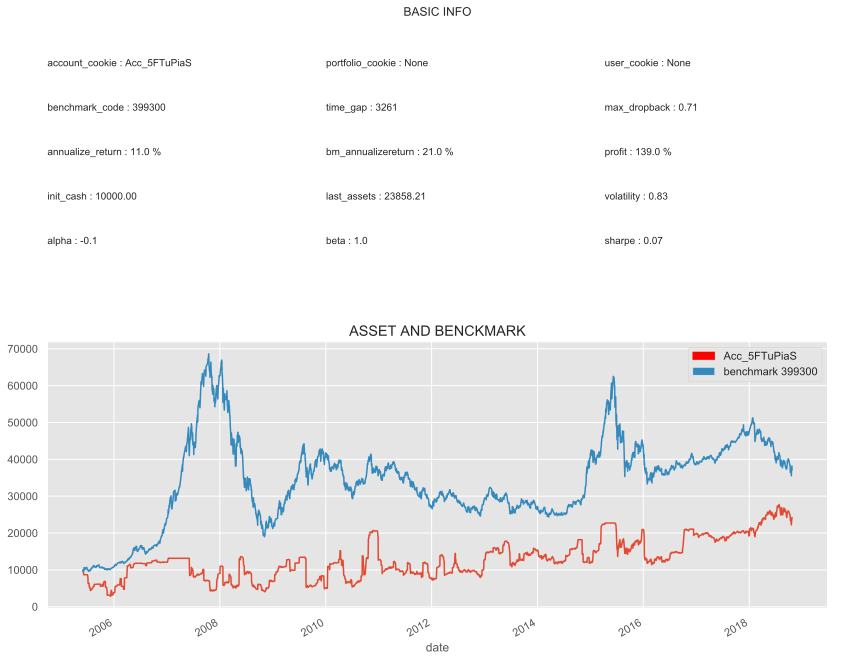

In [27]:
risk.plot_assets_curve()

# 单次购买量逐步增加的测试（每次加100股）

In [12]:
dict_size={}

for size in tqdm_notebook(range(100,600,100)):
    dict_size[size]=_bbands_single(lst,start_str,end_str,amount=size)

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>
receive deal

## Account相关

In [112]:
a=pd.DataFrame(columns=
               ['初始投入','可用资金','现有持仓持有均日期'],
               index=range(100,600,100))

for size in range(100,600,100):
    a.loc[size]['初始投入']=dict_size[size].init_cash
    a.loc[size]['可用资金']=dict_size[size].cash_available
    a.loc[size]['现有持仓持有均日期']=dict_size[size].hold_time().dt.days.mean()
a

,初始投入,可用资金,现有持仓持有均日期
100,10000,1571.21,218.5
200,10000,1651.88,205
300,10000,636.101,283.571
400,10000,890.868,256.4
500,10000,42.045,257


### 当前持仓

In [144]:
for size in range(100, 600, 100):
    pd.DataFrame({'': dict_size[size].hold,
                  'time': dict_size[size].hold_time().dt.days})

,,time
code,,
000739,300.0,215
000977,100.0,215
002013,200.0,236
002038,100.0,167
600535,100.0,488
600566,100.0,223
600572,100.0,129
600867,100.0,174
600885,100.0,171


,,time
code,,
000739,200.0,215
000977,200.0,215
002013,400.0,236
002038,200.0,167
600801,200.0,17
600867,200.0,174
600885,200.0,171
600967,400.0,445


,,time
code,,
000739,600.0,215
000977,300.0,215
000998,300.0,215
002013,600.0,236
600535,300.0,488
600885,300.0,171
600967,300.0,445


,,time
code,,
000739,400.0,215
000977,400.0,215
002013,400.0,236
600885,400.0,171
600967,400.0,445


,,time
code,,
000739,1000.0,215
000977,500.0,215
002013,1000.0,236
600867,500.0,174
600967,500.0,445


In [169]:
dict_size[100].daily_cash.cash[-1]

1571.2080000000033

## Performance相关

In [131]:
#计算期间内指数涨幅
zs_df=QA.QA_fetch_index_day_adv(zs_code,dict_size[100].start_date,dict_size[100].end_date).data
zs_profit=np.round(zs_df.iloc[-1]['close']/zs_df.iloc[0]['close']-1,2)#指数涨幅

In [135]:
p=pd.DataFrame(columns=
               ['总投入？','总收益？','收益比？','指数涨幅','胜率',],
               index=range(100,600,100))
for size in range(100,600,100):
    perf=quantaxis_ext.QA_Performance_Ext(dict_size[size])
    p.loc[size]['总投入？']=np.round((perf.pnl_fifo_qfq.buy_price * perf.pnl_fifo_qfq.amount).sum(),2)#总投入
    p.loc[size]['总收益？']=np.round(perf.pnl_fifo_qfq.pnl_money_qfq.sum(),2) #n总收益
    p.loc[size]['收益比？']=np.round(perf.pnl_fifo_qfq.pnl_money_qfq.sum()/dict_size[size].init_cash-1,2)
    p.loc[size]['胜率']=perf.win_rate_qfq()
    p.loc[size]['指数涨幅']=zs_profit
p

,总投入？,总收益？,收益比？,指数涨幅,胜率
100,330264,33372,2.34,2.72,0.78
200,389798,41072,3.11,2.72,0.75
300,481803,52371,4.24,2.72,0.78
400,423384,40776,3.08,2.72,0.72
500,457120,48000,3.8,2.72,0.76


## Risk相关报表

In [136]:
r=pd.DataFrame(columns=
               [['cashhold','cashhold','cashhold','利润','利润率','指数涨幅','波动率'],['max','min','mean','利润','利润率','指数涨幅','波动率']],
               index=range(100,600,100))
for size in range(100,600,100):
    risk=quantaxis_ext.QA_Risk_Ext(dict_size[size],benchmark_code=jupyter_helper.get_zs_code())
    r.loc[size]['cashhold']['min']=risk.min_cashhold
    r.loc[size]['cashhold']['max']=risk.max_cashhold
    r.loc[size]['cashhold']['mean']=risk.average_cashhold
    r.loc[size]['利润']['利润']=risk.profit_money
    r.loc[size]['利润率']['利润率']=risk.profit
    r.loc[size]['波动率']['波动率']=risk.volatility
    p.loc[size]['指数涨幅']=zs_profit
r

cashhold                        利润   利润率 指数涨幅   波动率
         max     min     mean       利润   利润率 指数涨幅   波动率
100  21016.3  33.477  5390.01  13858.2  1.39  NaN  0.83
200  23988.9   4.496  5249.81  18747.9  1.87  NaN  1.09
300  34931.7  47.495  7206.33  28682.1  2.87  NaN  1.09
400    22668  13.648  5933.29  19202.9  1.92  NaN  1.07
500  35842.9   17.19  6530.84    36517  3.65  NaN  1.35

In [139]:
qqqq=quantaxis_ext.QA_Risk_Ext(dict_size[100],benchmark_code=jupyter_helper.get_zs_code())

In [140]:
qqqq.profit_construct

{'total_buyandsell': 16173.0,
 'total_commission': -1965.0,
 'total_profit': 13858.21,
 'total_tax': -349.79}

**当前持仓总价值**，Risk在计算利润时不考虑这部分

In [175]:
qqqq.market_value.iloc[-1].sum()

22287.0